In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain3 import Gain3
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerPmd2 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0, 0.1]
gSlope_bound = [0,0]


# Generate a batch of trials with linear gain

In [3]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound, 
                        noise = 0.25, accumulation_mask = 300)

In [4]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 2,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [0, 1],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g0_bound': [0, 0.1],
 'gSlope_bound': [0, 0]}

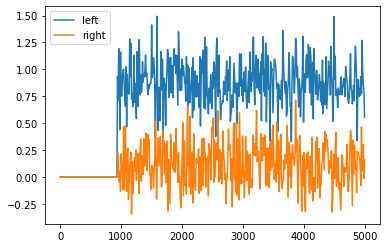

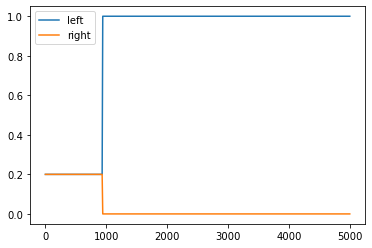

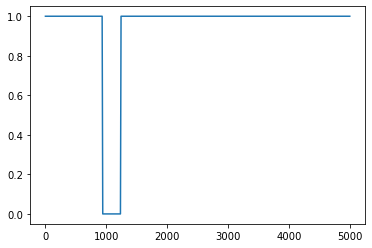

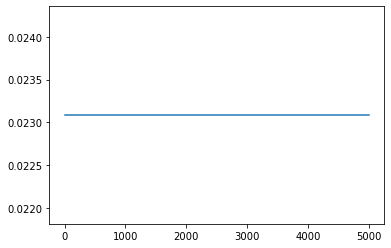

[0.02308516 0.        ]
{'coherence': 0.8740877609938061, 'noise': 0.25, 'accumulation_mask': 300, 'target_onset': 376, 'checker_onset': 557, 'g0_bound': [0, 0.1], 'gSlope_bound': [0, 0]}


In [5]:
[x, y, mask, allParams, g, gainParams] = task.get_trial_batch()

trialNum = 1
# x[1]: left tartet evidence
# x[2]: right target evidence
trialIn = x[trialNum,:,:]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])
# plot gain
plt.figure()
plt.plot(time, g[trialNum,:,:])
plt.show()
print(gainParams[trialNum,:])
print(allParams[trialNum])

# Set Network params

In [6]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

# Dale's ratio
# network_params['dale_ratio'] = 0.8

In [7]:
try:
    model.destruct()
except:
    pass

model = Gain3(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [8]:
# check model
# vars(model)

# Set Training params & Train

In [9]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  './weights/gain3Dale0.8'
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [10]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = './losses/gain3Dale0.8.txt'
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.206775
Iter 1000, Minibatch Loss= 0.169198
Iter 1500, Minibatch Loss= 0.127823
Iter 2000, Minibatch Loss= 0.144688
Iter 2500, Minibatch Loss= 0.137847
Iter 3000, Minibatch Loss= 0.091746
Iter 3500, Minibatch Loss= 0.050723
Iter 4000, Minibatch Loss= 0.050364
Iter 4500, Minibatch Loss= 0.063951
Iter 5000, Minibatch Loss= 0.053290
Iter 5500, Minibatch Loss= 0.037745
Iter 6000, Minibatch Loss= 0.035709
Iter 6500, Minibatch Loss= 0.034373
Iter 7000, Minibatch Loss= 0.028655
Iter 7500, Minibatch Loss= 0.031956
Iter 8000, Minibatch Loss= 0.035821
Iter 8500, Minibatch Loss= 0.029828
Iter 9000, Minibatch Loss= 0.028286
Iter 9500, Minibatch Loss= 0.019590
Iter 10000, Minibatch Loss= 0.023460
Iter 10500, Minibatch Loss= 0.030846
Iter 11000, Minibatch Loss= 0.021675
Iter 11500, Minibatch Loss= 0.024282
Iter 12000, Minibatch Loss= 0.016225
Iter 12500, Minibatch Loss= 0.021596
I

Text(0.5, 1.0, 'Loss During Training')

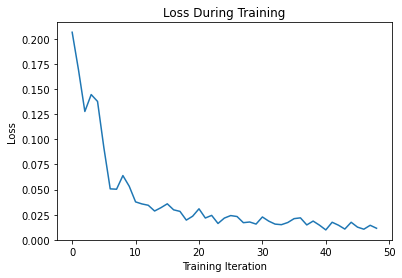

In [11]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

# Check Weights

In [ ]:
# # define weights path
# weightsPath = './weights/checkerPmdGain3NoPreTrain.npz'
# # read saved weights
# weights = dict(np.load(weightsPath, allow_pickle = True))

# or read weights parameters from model function
weights = model.get_weights()
# plot_weights(weights['W_rec'])
W_in = weights['W_in']
W_out = weights['W_out']
W_rec = weights['W_rec']

In [ ]:
plt.imshow(W_rec, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

print(W_rec.shape)
print(np.sum(W_rec > 0))

In [ ]:
W_recP = W_rec[W_rec > 0]
print(np.sum(W_recP))
W_recN = W_rec[W_rec < 0]
print(np.sum(W_recN))

W_inP = W_in[W_in > 0]
print(np.sum(W_inP))
W_inN = W_in[W_in < 0]
print(np.sum(W_inN))

W_outP = W_out[W_out > 0]
print(np.sum(W_outP))
W_outN = W_out[W_out < 0]
print(np.sum(W_outN))

In [ ]:
sum1 = np.zeros((1000,1))
sum2 = np.zeros((1000,1))
for i in range(sum1.shape[0]):
    simu = np.random.uniform(0, 1, 100)
    simu2 =2*np.random.uniform(0, 1, 100)
#     simu = np.random.uniform(-1, 1, 100)
#     simu2 =2*np.random.uniform(-1, 1, 100)
    r1 = np.dot(W_rec, simu)
    r2 = np.dot(W_rec, simu2)
    sum1[i] = np.sum(r1)
    sum2[i] = np.sum(r2)
    
np.sum(sum2 > sum1)

# Test 5000 trials

In [12]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)
g0 = np.zeros(trials)
gSlope = np.zeros(trials)

In [13]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, gainParams] = task.get_trial_batch()
    outputs, states, inputs = model.test(x,g)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 
        g0[index] = gainParams[i][0]
        gSlope[index] = gainParams[i][1]

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [ ]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10,20):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])

    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
    plt.figure()
    plt.plot(np.arange(0, T, 10), g[i, :, :])

In [14]:
correct_side = (coherence > 0.5)
correct_side = 1 - 1*correct_side

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : 2*coherence - 1,
                           'coherence_bin' : np.round(2*coherence - 1, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'g0' : g0,
                          'gSlope' : gSlope})

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))




Overall Accuracy: 0.9562
Negative RT trials ratio: 0.0


In [ ]:
checker_df

In [15]:
#######################
## summary result save path

resultPath = "./resultData/gain3Dale0.8.csv"
checker_df.to_csv(resultPath)

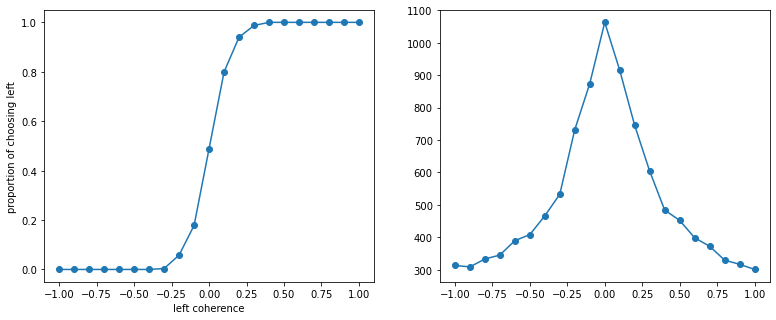

In [16]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.scatter(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.xlabel("left coherence")
plt.ylabel("proportion of choosing left")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



# RT within same coherence

In [ ]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# Check the activity of each recurrent unit

In [ ]:
trial_num = 5
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

In [ ]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("temp.mat", mdic)

In [ ]:
model.destruct()

# 2. Load the model trained before

In [ ]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0, 1]
gSlope_bound = [0,0.005]

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound)

########################################
#### set weight path
########################################
weightsPath = "./weights/Gain3AdditiveRecNoise0.1.npz"

network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

        
network_params['load_weights_path'] =  weightsPath

try:
    model2.destruct()
except:
    pass

model2 = Gain3(network_params)
model2.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model2.decision_threshold = network_params.get("decision_threshold", np.inf)

# Test 5000 trials to examine performance

In [ ]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model2.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model2.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [ ]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, gainParams] = task.get_trial_batch()
    outputs, states, inputs = model2.test(x,g)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]           

In [ ]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(20,30):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 3])
    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
    plt.figure()
    plt.plot(np.arange(0, T, 10), g[i, :, :])

# Generate a dataframe

In [ ]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))

## save the result summary
# resultPath = "./resultData/Gain31stTryRecNoise0.1.csv"
# checker_df.to_csv(resultPath)

In [ ]:
# psychrometric curve 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

In [ ]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1
    
idx = 1
plt.figure(figsize=(15, 8))
for i in [-0.9,-0.7,-0.5,-0.3,-0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1


# Check the activity of each recurrent unit

In [ ]:
trial_num = 12
print(checker_df.loc[trial_num])
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()


In [ ]:
model2.destruct()